In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_deit_model(architecture='deit_base_patch16_224', num_classes=4, pretrained=True):
    """
    Create DeiT (Data-efficient Image Transformer) model for multi-class classification
    
    Args:
        architecture (str): DeiT architecture - 'deit_tiny_patch16_224', 'deit_small_patch16_224', or 'deit_base_patch16_224'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: DeiT model from timm library
    """
    if architecture == 'deit_tiny_patch16_224':
        model = timm.create_model('deit_tiny_patch16_224', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'deit_small_patch16_224':
        model = timm.create_model('deit_small_patch16_224', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'deit_base_patch16_224':
        model = timm.create_model('deit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'deit_tiny_patch16_224', 'deit_small_patch16_224', or 'deit_base_patch16_224'")
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train DeiT Tiny

Training DeiT Tiny


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:04<00:00,  8.28it/s, Loss=1.4099, Acc=0.3150]


Train Loss: 1.4099 Acc: 0.3150 Macro-F1: 0.2928


Val : 100%|██████████| 10/10 [00:01<00:00,  6.77it/s, Loss=1.2288, Acc=0.4737]


Val Loss: 1.2288 Acc: 0.4737 Macro-F1: 0.3079
✓ New best model saved with validation macro-F1: 0.3079

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.46it/s, Loss=1.1790, Acc=0.4539]


Train Loss: 1.1790 Acc: 0.4539 Macro-F1: 0.4251


Val : 100%|██████████| 10/10 [00:00<00:00, 10.43it/s, Loss=1.0392, Acc=0.5691]


Val Loss: 1.0392 Acc: 0.5691 Macro-F1: 0.4541
✓ New best model saved with validation macro-F1: 0.4541

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.52it/s, Loss=1.0633, Acc=0.5641]


Train Loss: 1.0633 Acc: 0.5641 Macro-F1: 0.5180


Val : 100%|██████████| 10/10 [00:00<00:00, 10.18it/s, Loss=0.9178, Acc=0.5888]


Val Loss: 0.9178 Acc: 0.5888 Macro-F1: 0.5333
✓ New best model saved with validation macro-F1: 0.5333

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.63it/s, Loss=0.9110, Acc=0.6538]


Train Loss: 0.9110 Acc: 0.6538 Macro-F1: 0.6072


Val : 100%|██████████| 10/10 [00:00<00:00, 10.28it/s, Loss=0.7690, Acc=0.6875]


Val Loss: 0.7690 Acc: 0.6875 Macro-F1: 0.6768
✓ New best model saved with validation macro-F1: 0.6768

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.57it/s, Loss=0.6420, Acc=0.7722]


Train Loss: 0.6420 Acc: 0.7722 Macro-F1: 0.7330


Val : 100%|██████████| 10/10 [00:00<00:00, 10.24it/s, Loss=0.4804, Acc=0.8224]


Val Loss: 0.4804 Acc: 0.8224 Macro-F1: 0.7876
✓ New best model saved with validation macro-F1: 0.7876

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.35it/s, Loss=0.6931, Acc=0.7303]


Train Loss: 0.6931 Acc: 0.7303 Macro-F1: 0.6907


Val : 100%|██████████| 10/10 [00:00<00:00, 10.21it/s, Loss=0.9035, Acc=0.6250]


Val Loss: 0.9035 Acc: 0.6250 Macro-F1: 0.5931

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.35it/s, Loss=0.5632, Acc=0.7993]


Train Loss: 0.5632 Acc: 0.7993 Macro-F1: 0.7654


Val : 100%|██████████| 10/10 [00:01<00:00,  9.87it/s, Loss=0.4744, Acc=0.8059]


Val Loss: 0.4744 Acc: 0.8059 Macro-F1: 0.7878
✓ New best model saved with validation macro-F1: 0.7878

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.06it/s, Loss=0.3131, Acc=0.9038]


Train Loss: 0.3131 Acc: 0.9038 Macro-F1: 0.8832


Val : 100%|██████████| 10/10 [00:00<00:00, 10.12it/s, Loss=0.2659, Acc=0.9079]


Val Loss: 0.2659 Acc: 0.9079 Macro-F1: 0.8721
✓ New best model saved with validation macro-F1: 0.8721

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.59it/s, Loss=0.1873, Acc=0.9457]


Train Loss: 0.1873 Acc: 0.9457 Macro-F1: 0.9374


Val : 100%|██████████| 10/10 [00:00<00:00, 10.41it/s, Loss=0.2000, Acc=0.9441]


Val Loss: 0.2000 Acc: 0.9441 Macro-F1: 0.9310
✓ New best model saved with validation macro-F1: 0.9310

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.14it/s, Loss=0.1274, Acc=0.9605]


Train Loss: 0.1274 Acc: 0.9605 Macro-F1: 0.9548


Val : 100%|██████████| 10/10 [00:00<00:00, 10.21it/s, Loss=0.1678, Acc=0.9474]


Val Loss: 0.1678 Acc: 0.9474 Macro-F1: 0.9357
✓ New best model saved with validation macro-F1: 0.9357

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.58it/s, Loss=0.0906, Acc=0.9737]


Train Loss: 0.0906 Acc: 0.9737 Macro-F1: 0.9675


Val : 100%|██████████| 10/10 [00:01<00:00,  9.81it/s, Loss=0.1536, Acc=0.9539]


Val Loss: 0.1536 Acc: 0.9539 Macro-F1: 0.9499
✓ New best model saved with validation macro-F1: 0.9499

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.29it/s, Loss=0.0582, Acc=0.9827]


Train Loss: 0.0582 Acc: 0.9827 Macro-F1: 0.9840


Val : 100%|██████████| 10/10 [00:00<00:00, 10.53it/s, Loss=0.1396, Acc=0.9605]


Val Loss: 0.1396 Acc: 0.9605 Macro-F1: 0.9422

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.69it/s, Loss=0.0312, Acc=0.9942]


Train Loss: 0.0312 Acc: 0.9942 Macro-F1: 0.9931


Val : 100%|██████████| 10/10 [00:00<00:00, 10.45it/s, Loss=0.1404, Acc=0.9605]


Val Loss: 0.1404 Acc: 0.9605 Macro-F1: 0.9422

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.07it/s, Loss=0.0172, Acc=0.9975]


Train Loss: 0.0172 Acc: 0.9975 Macro-F1: 0.9981


Val : 100%|██████████| 10/10 [00:00<00:00, 10.22it/s, Loss=0.1391, Acc=0.9605]


Val Loss: 0.1391 Acc: 0.9605 Macro-F1: 0.9422

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.67it/s, Loss=0.0112, Acc=0.9992]


Train Loss: 0.0112 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:00<00:00, 10.49it/s, Loss=0.1408, Acc=0.9605]


Val Loss: 0.1408 Acc: 0.9605 Macro-F1: 0.9422

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:03<00:00, 10.57it/s, Loss=0.0111, Acc=0.9992]


Train Loss: 0.0111 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:01<00:00,  9.38it/s, Loss=0.1416, Acc=0.9605]


Val Loss: 0.1416 Acc: 0.9605 Macro-F1: 0.9422
Early stopping triggered after 16 epochs
Training complete in 1m 16s
Best validation macro-F1: 0.9499


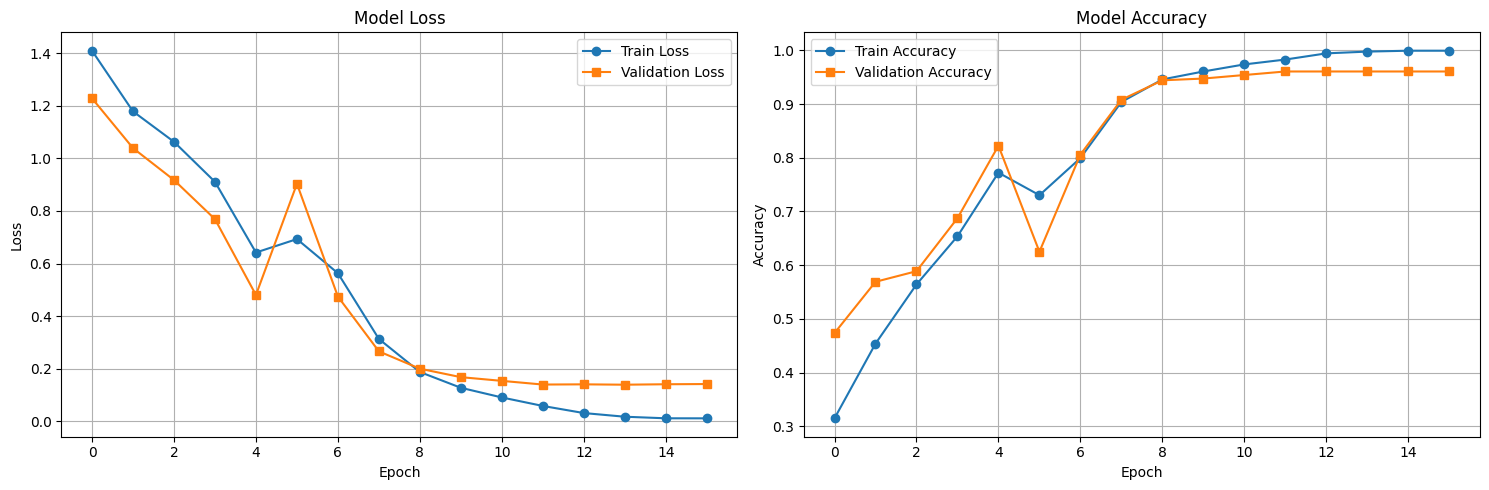

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Test Accuracy: 37.04%
Test Loss: 2.6734

Classification Report:
              precision    recall  f1-score   support

         HGC       0.49      0.39      0.44        74
         LGC       0.24      0.15      0.19        53
         NST       0.42      0.59      0.49        37
         NTL       0.24      0.44      0.31        25

    accuracy                           0.37       189
   macro avg       0.35      0.39      0.36       189
weighted avg       0.38      0.37      0.36       189


Confusion Matrix:
[[29 13 20 12]
 [26  8  2 17]
 [ 4  6 22  5]
 [ 0  6  8 11]]

ROC-AUC Scores:
Macro-average AUC: 0.6660
Micro-average AUC: 0.6470
HGC AUC: 0.6525
LGC AUC: 0.4717
NST AUC: 0.7987
NTL AUC: 0.7410


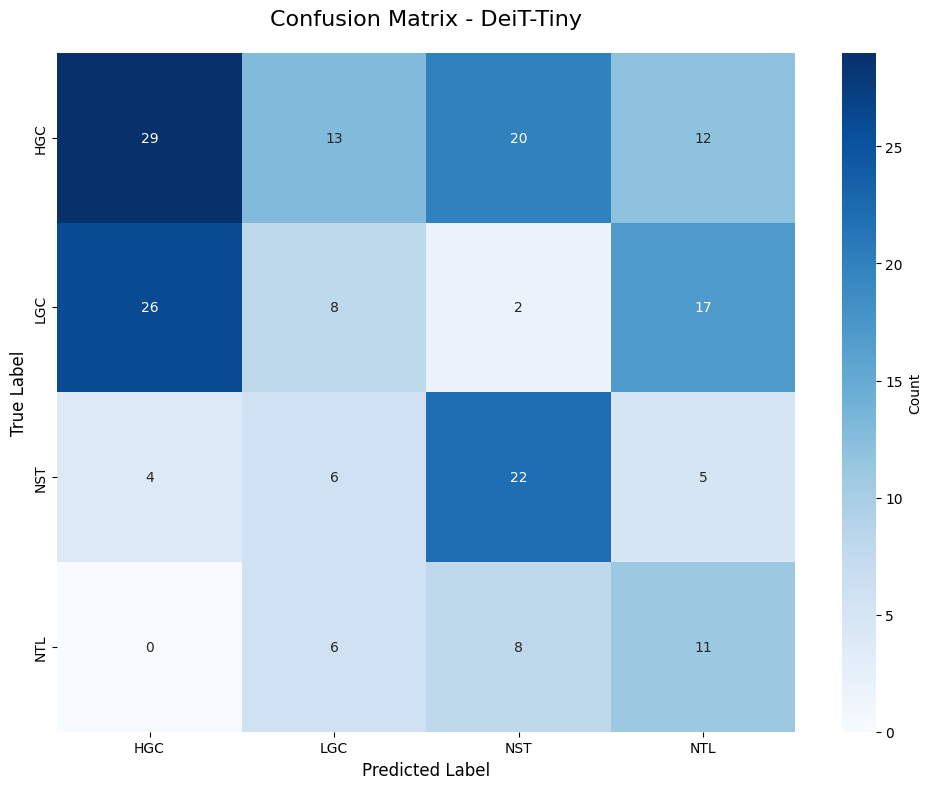

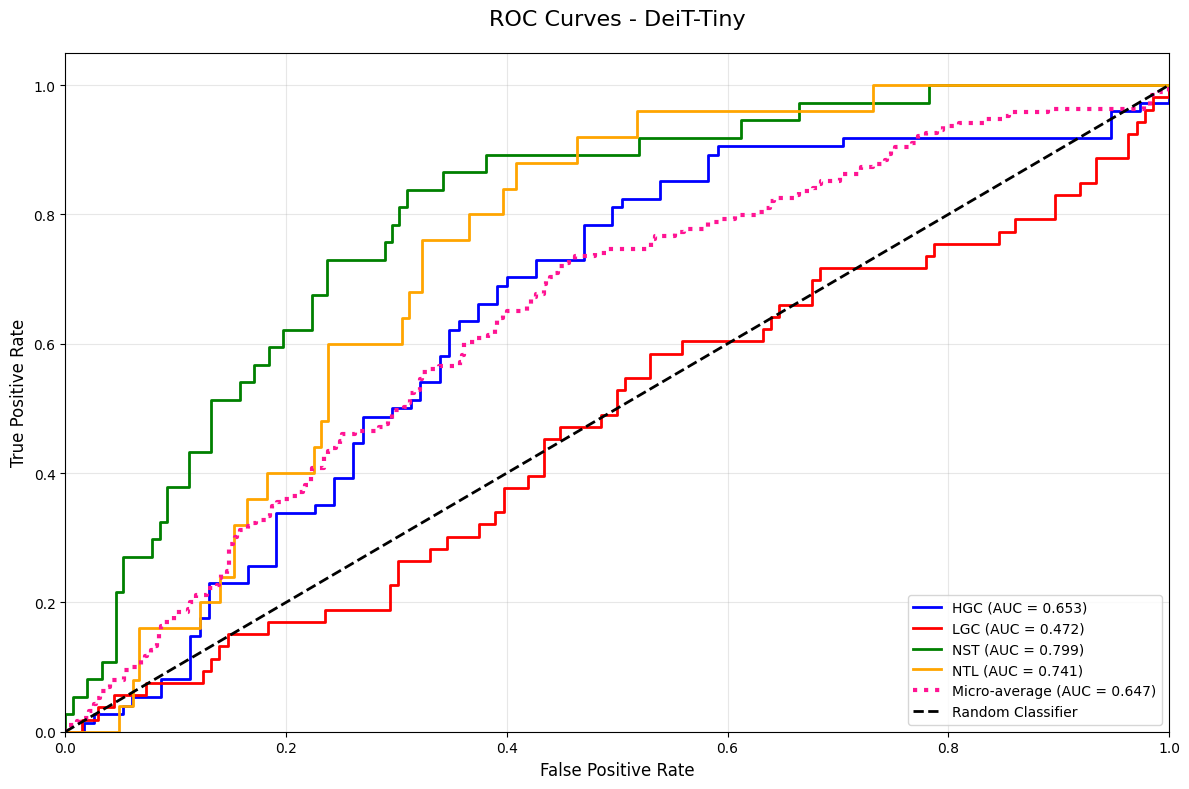


DeiT-Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training DeiT Tiny")
print("=" * 80)

# Create model
deit_tiny = create_deit_model(architecture='deit_tiny_patch16_224', num_classes=4, pretrained=True)

# Create trainer
trainer_deit_tiny = ModelTrainer(deit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_tiny = trainer_deit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Tiny")

# Plot training history
trainer_deit_tiny.plot_training_history(save_path='deit_tiny_training_history.png')

# Evaluate model
results_deit_tiny = trainer_deit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_tiny['confusion_matrix'], class_names, 'DeiT-Tiny',
                      save_path='deit_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_tiny = plot_roc_curves(results_deit_tiny['labels'], results_deit_tiny['probabilities'], class_names, 'DeiT-Tiny',
                                     save_path='deit_tiny_roc_curves.png')

# Store results
results_deit_tiny['model_name'] = 'DeiT-Tiny'
results_deit_tiny['roc_auc'] = roc_auc_deit_tiny
all_results.append(results_deit_tiny)

print("\nDeiT-Tiny training and evaluation complete!")

## Train DeiT Base

Training DeiT Base


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.5368, Acc=0.2541]


Train Loss: 1.5368 Acc: 0.2541 Macro-F1: 0.2274


Val : 100%|██████████| 10/10 [00:02<00:00,  4.32it/s, Loss=1.3770, Acc=0.2895]


Val Loss: 1.3770 Acc: 0.2895 Macro-F1: 0.1269
✓ New best model saved with validation macro-F1: 0.1269

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.62it/s, Loss=1.4461, Acc=0.2270]


Train Loss: 1.4461 Acc: 0.2270 Macro-F1: 0.2161


Val : 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, Loss=1.3904, Acc=0.0724]


Val Loss: 1.3904 Acc: 0.0724 Macro-F1: 0.0337

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.3075, Acc=0.4243]


Train Loss: 1.3075 Acc: 0.4243 Macro-F1: 0.3573


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=1.2629, Acc=0.4013]


Val Loss: 1.2629 Acc: 0.4013 Macro-F1: 0.3033
✓ New best model saved with validation macro-F1: 0.3033

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=1.3279, Acc=0.3799]


Train Loss: 1.3279 Acc: 0.3799 Macro-F1: 0.3458


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=1.1853, Acc=0.4737]


Val Loss: 1.1853 Acc: 0.4737 Macro-F1: 0.3137
✓ New best model saved with validation macro-F1: 0.3137

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.1554, Acc=0.5173]


Train Loss: 1.1554 Acc: 0.5173 Macro-F1: 0.4263


Val : 100%|██████████| 10/10 [00:02<00:00,  4.20it/s, Loss=1.2497, Acc=0.4770]


Val Loss: 1.2497 Acc: 0.4770 Macro-F1: 0.3915
✓ New best model saved with validation macro-F1: 0.3915

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.1243, Acc=0.4951]


Train Loss: 1.1243 Acc: 0.4951 Macro-F1: 0.4587


Val : 100%|██████████| 10/10 [00:02<00:00,  4.27it/s, Loss=1.0029, Acc=0.6020]


Val Loss: 1.0029 Acc: 0.6020 Macro-F1: 0.5080
✓ New best model saved with validation macro-F1: 0.5080

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.0948, Acc=0.5428]


Train Loss: 1.0948 Acc: 0.5428 Macro-F1: 0.5048


Val : 100%|██████████| 10/10 [00:02<00:00,  4.26it/s, Loss=0.9386, Acc=0.5263]


Val Loss: 0.9386 Acc: 0.5263 Macro-F1: 0.4436

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.8797, Acc=0.6086]


Train Loss: 0.8797 Acc: 0.6086 Macro-F1: 0.5790


Val : 100%|██████████| 10/10 [00:02<00:00,  4.22it/s, Loss=0.8361, Acc=0.6743]


Val Loss: 0.8361 Acc: 0.6743 Macro-F1: 0.6112
✓ New best model saved with validation macro-F1: 0.6112

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.7664, Acc=0.6916]


Train Loss: 0.7664 Acc: 0.6916 Macro-F1: 0.6593


Val : 100%|██████████| 10/10 [00:02<00:00,  4.24it/s, Loss=0.7696, Acc=0.6678]


Val Loss: 0.7696 Acc: 0.6678 Macro-F1: 0.6413
✓ New best model saved with validation macro-F1: 0.6413

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.6892, Acc=0.7007]


Train Loss: 0.6892 Acc: 0.7007 Macro-F1: 0.6737


Val : 100%|██████████| 10/10 [00:02<00:00,  4.22it/s, Loss=0.7396, Acc=0.6908]


Val Loss: 0.7396 Acc: 0.6908 Macro-F1: 0.6566
✓ New best model saved with validation macro-F1: 0.6566

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6397, Acc=0.7179]


Train Loss: 0.6397 Acc: 0.7179 Macro-F1: 0.6983


Val : 100%|██████████| 10/10 [00:02<00:00,  4.21it/s, Loss=0.6764, Acc=0.7401]


Val Loss: 0.6764 Acc: 0.7401 Macro-F1: 0.7038
✓ New best model saved with validation macro-F1: 0.7038

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.6243, Acc=0.7393]


Train Loss: 0.6243 Acc: 0.7393 Macro-F1: 0.7180


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=0.6844, Acc=0.7105]


Val Loss: 0.6844 Acc: 0.7105 Macro-F1: 0.6784

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.5890, Acc=0.7426]


Train Loss: 0.5890 Acc: 0.7426 Macro-F1: 0.7261


Val : 100%|██████████| 10/10 [00:02<00:00,  4.24it/s, Loss=0.6846, Acc=0.7138]


Val Loss: 0.6846 Acc: 0.7138 Macro-F1: 0.6955

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.5715, Acc=0.7673]


Train Loss: 0.5715 Acc: 0.7673 Macro-F1: 0.7470


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=0.7272, Acc=0.6842]


Val Loss: 0.7272 Acc: 0.6842 Macro-F1: 0.6494

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.5045, Acc=0.7985]


Train Loss: 0.5045 Acc: 0.7985 Macro-F1: 0.7822


Val : 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, Loss=0.6107, Acc=0.7763]


Val Loss: 0.6107 Acc: 0.7763 Macro-F1: 0.7396
✓ New best model saved with validation macro-F1: 0.7396

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.4724, Acc=0.8183]


Train Loss: 0.4724 Acc: 0.8183 Macro-F1: 0.8028


Val : 100%|██████████| 10/10 [00:02<00:00,  4.26it/s, Loss=0.6069, Acc=0.7697]


Val Loss: 0.6069 Acc: 0.7697 Macro-F1: 0.7321

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4605, Acc=0.8191]


Train Loss: 0.4605 Acc: 0.8191 Macro-F1: 0.8038


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.5858, Acc=0.7895]


Val Loss: 0.5858 Acc: 0.7895 Macro-F1: 0.7563
✓ New best model saved with validation macro-F1: 0.7563

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=0.4450, Acc=0.8207]


Train Loss: 0.4450 Acc: 0.8207 Macro-F1: 0.8094


Val : 100%|██████████| 10/10 [00:02<00:00,  4.25it/s, Loss=0.5837, Acc=0.7895]


Val Loss: 0.5837 Acc: 0.7895 Macro-F1: 0.7557

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4433, Acc=0.8289]


Train Loss: 0.4433 Acc: 0.8289 Macro-F1: 0.8176


Val : 100%|██████████| 10/10 [00:02<00:00,  4.24it/s, Loss=0.5794, Acc=0.7928]


Val Loss: 0.5794 Acc: 0.7928 Macro-F1: 0.7592
✓ New best model saved with validation macro-F1: 0.7592

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4303, Acc=0.8306]


Train Loss: 0.4303 Acc: 0.8306 Macro-F1: 0.8176


Val : 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, Loss=0.5762, Acc=0.7928]


Val Loss: 0.5762 Acc: 0.7928 Macro-F1: 0.7568

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4269, Acc=0.8331]


Train Loss: 0.4269 Acc: 0.8331 Macro-F1: 0.8245


Val : 100%|██████████| 10/10 [00:02<00:00,  4.23it/s, Loss=0.5691, Acc=0.7993]


Val Loss: 0.5691 Acc: 0.7993 Macro-F1: 0.7648
✓ New best model saved with validation macro-F1: 0.7648

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4136, Acc=0.8372]


Train Loss: 0.4136 Acc: 0.8372 Macro-F1: 0.8286


Val : 100%|██████████| 10/10 [00:02<00:00,  4.28it/s, Loss=0.5701, Acc=0.8092]


Val Loss: 0.5701 Acc: 0.8092 Macro-F1: 0.7785
✓ New best model saved with validation macro-F1: 0.7785

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4146, Acc=0.8388]


Train Loss: 0.4146 Acc: 0.8388 Macro-F1: 0.8297


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.5711, Acc=0.7993]


Val Loss: 0.5711 Acc: 0.7993 Macro-F1: 0.7683

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4112, Acc=0.8396]


Train Loss: 0.4112 Acc: 0.8396 Macro-F1: 0.8299


Val : 100%|██████████| 10/10 [00:02<00:00,  4.21it/s, Loss=0.5738, Acc=0.7993]


Val Loss: 0.5738 Acc: 0.7993 Macro-F1: 0.7664

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.61it/s, Loss=0.4113, Acc=0.8396]


Train Loss: 0.4113 Acc: 0.8396 Macro-F1: 0.8298


Val : 100%|██████████| 10/10 [00:02<00:00,  4.27it/s, Loss=0.5741, Acc=0.7993]


Val Loss: 0.5741 Acc: 0.7993 Macro-F1: 0.7664

Training complete in 10m 59s
Best validation macro-F1: 0.7785


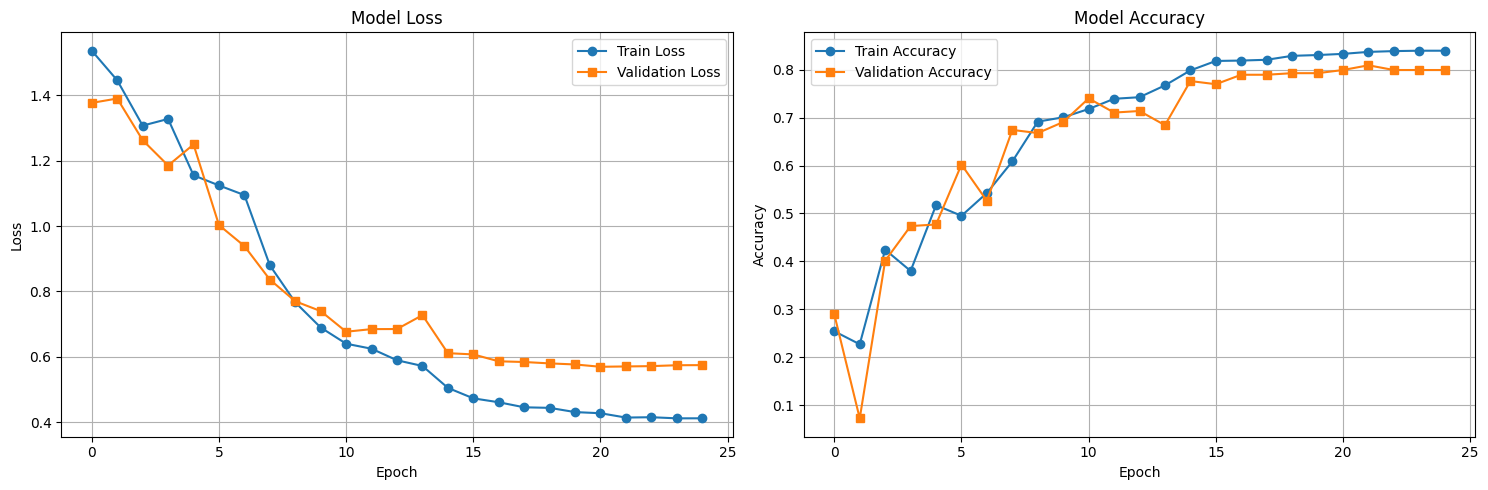

<Figure size 640x480 with 0 Axes>

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Test Accuracy: 26.98%
Test Loss: 2.9555

Classification Report:
              precision    recall  f1-score   support

         HGC       0.54      0.30      0.38        74
         LGC       0.17      0.08      0.11        53
         NST       0.10      0.11      0.10        37
         NTL       0.25      0.84      0.38        25

    accuracy                           0.27       189
   macro avg       0.26      0.33      0.24       189
weighted avg       0.31      0.27      0.25       189


Confusion Matrix:
[[22 15 35  2]
 [19  4  1 29]
 [ 0  0  4 33]
 [ 0  4  0 21]]

ROC-AUC Scores:
Macro-average AUC: 0.6706
Micro-average AUC: 0.5746
HGC AUC: 0.7720
LGC AUC: 0.6138
NST AUC: 0.5352
NTL AUC: 0.7612


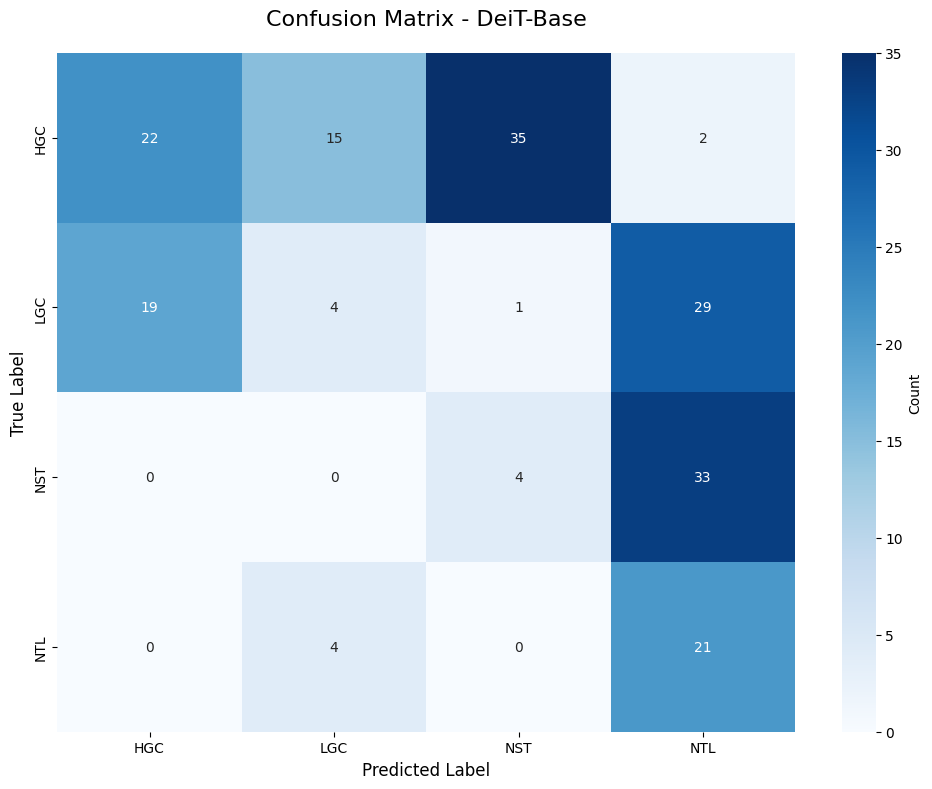

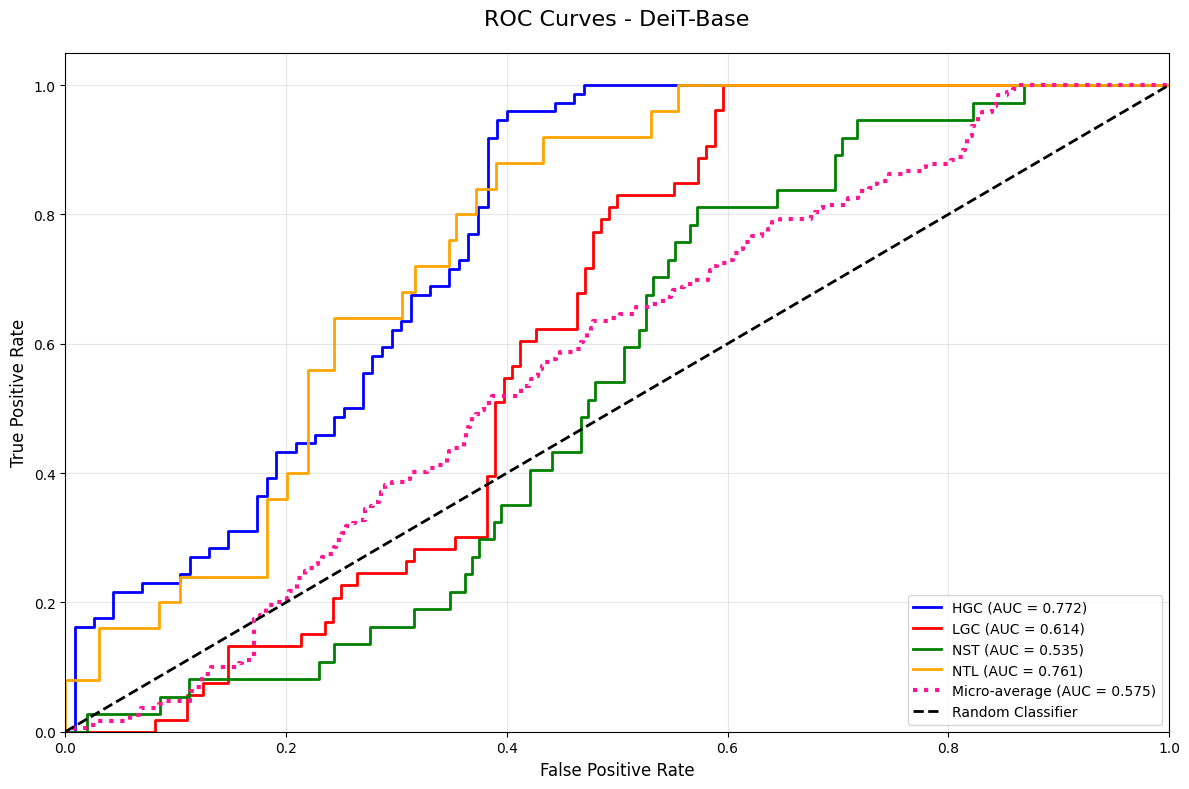


DeiT-Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training DeiT Base")
print("=" * 80)

# Create model
deit_base = create_deit_model(architecture='deit_base_patch16_224', num_classes=4, pretrained=True)

# Create trainer
trainer_deit_base = ModelTrainer(deit_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_deit_base = trainer_deit_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="DeiT-Base")

# Plot training history
trainer_deit_base.plot_training_history(save_path='deit_base_training_history.png')

# Evaluate model
results_deit_base = trainer_deit_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_deit_base['confusion_matrix'], class_names, 'DeiT-Base',
                      save_path='deit_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_deit_base = plot_roc_curves(results_deit_base['labels'], results_deit_base['probabilities'], class_names, 'DeiT-Base',
                                     save_path='deit_base_roc_curves.png')

# Store results
results_deit_base['model_name'] = 'DeiT-Base'
results_deit_base['roc_auc'] = roc_auc_deit_base
all_results.append(results_deit_base)

print("\nDeiT-Base training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'DeiT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: DeiT_metrics.csv

Metrics Summary:
       Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  DeiT-Tiny         37.037037      2.673365             0.350368          0.394357      0.357701                0.375589             0.370370         0.361272       0.491525    0.391892  0.436090         74.0       0.242424    0.150943  0.186047         53.0       0.423077    0.594595  0.494382         37.0       0.244444        0.44  0.314286         25.0   0.665980   0.647042  0.652526  0.471698  0.798720  0.740976      0.652526      0.47169